In [ ]:
#! pip install gensim
# !pip install datasets transformers
# !pip install tensorflow-addons
# !pip install keras_preprocessing

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [ ]:
df=pd.read_csv('/content/ner_dataset.csv', encoding= 'unicode_escape')

In [ ]:
df['Sentence #']=df['Sentence #'].ffill()

In [ ]:
df=df[['Sentence #','Word','Tag']]
df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)

In [ ]:
df.info() #There seems to be no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Token     1048575 non-null  object
 2   POS       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [ ]:
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Token'].nunique()))

Number of sentences are 47959
Number of Vocabs are 35178


# Model Building LSTM and CRF

## Data Preprocessing

In [ ]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [ ]:
df['Token']=df['Token'].str.lower()

In [ ]:
sentence_all = [(list(zip(group['Token'], group['POS']))) for _, group in df.groupby('Sentence')]

In [ ]:
sentence_all[0] #1st Sentence

[('thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('london', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('british', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [ ]:
# sentences = []
# for sample in sentence_all:
#   sentence = [i[0] for i in sample]
#   sentences.append(sentence)

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=df['Token'].nunique(), lower=True)
# tokenizer.fit_on_texts(sentences)

In [ ]:
#tokenizer.shape

In [ ]:
#tokenizer.word_index.items()

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
#BATCH_SIZE

In [ ]:
words = list(set(df['Token'].values))
tags = list(set(df["POS"].values))

In [ ]:
'thousands'in words

True

In [ ]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}


In [ ]:
#'thousands' in list(word2idx.keys())

In [ ]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Converted 19600 words (12219 misses)


In [ ]:
#! pip install keras_preprocessing

In [ ]:
#Tagging word to index and tag to index

#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  iranian officials say they expect to get access to sealed sensitive parts of the plant wednesday , after an iaea surveillance system begins functioning .

 
Raw Label:
  B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O

 
After processing, sample:
 [17579 23640 18801 19313 14372 23219 27663  2349  6029 14046 19622 24466
 16428 16768  3452 14046 20154 23640 14157 21553 30883  7152   151 12852
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
#sentence_all

In [ ]:
len(word2idx)

31819

In [ ]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

In [ ]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [ ]:
#! pip install tensorflow_addons

In [ ]:
# !pip install tensorflow-addons
# !pip install tensorflow==2.0.0-beta1

## Model Building

In [ ]:
#len(word2idx)

In [ ]:
#!pip install tensorflow-addons

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(18, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 75, 300)          9545700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 75, 100)          140400    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 75, 200)          160800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 75, 100)          100400    
 nal)                                                            
                                                           

## Evaluation

In [ ]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=10,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20


675/675 [==============================] - ETA: 0s - loss: 0.2761
Epoch 1: val_loss improved from inf to 0.09992, saving model to ner_crf.h5
675/675 [==============================] - 892s 1s/step - loss: 0.2761 - val_loss: 0.0999
Epoch 2/20
675/675 [==============================] - ETA: 0s - loss: 0.0663
Epoch 2: val_loss improved from 0.09992 to 0.04717, saving model to ner_crf.h5
675/675 [==============================] - 837s 1s/step - loss: 0.0663 - val_loss: 0.0472
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0394
Epoch 3: val_loss improved from 0.04717 to 0.03354, saving model to ner_crf.h5
675/675 [==============================] - 854s 1s/step - loss: 0.0394 - val_loss: 0.0335
Epoch 4/20
675/675 [==============================] - ETA: 0s - loss: 0.0277
Epoch 4: val_loss improved from 0.03354 to 0.02571, saving model to ner_crf.h5
675/675 [==============================] - 856s 1s/step - loss: 0.0277 - val_loss: 0.0257
Epoch 5/20
675/675 [===========

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

Since it's still reducing there is a chance it will reduce more with more hyperparam tuning but loss of 0.02 for train and 0.14 with test looks great

150/150 [==============================] - 33s 148ms/step


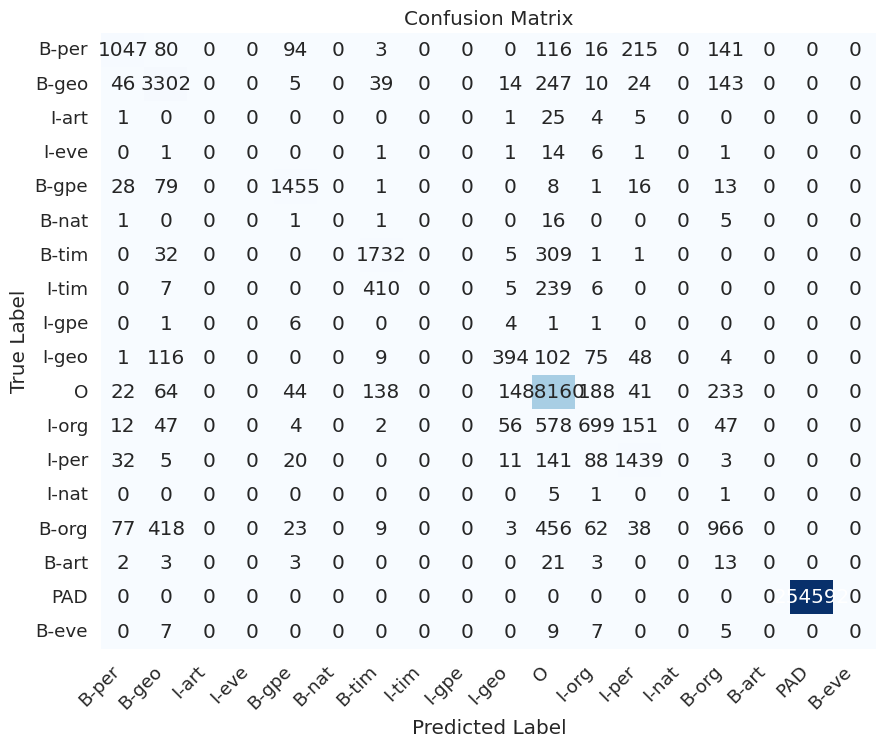

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                precision    recall  f1-score   support

       B-per       0.61      0.83      0.70      1269
       B-geo       0.86      0.79      0.83      4162
       I-art       0.00      0.00      0.00         0
       I-eve       0.00      0.00      0.00         0
       B-gpe       0.91      0.88      0.89      1655
       B-nat       0.00      0.00      0.00         0
       B-tim       0.83      0.74      0.78      2345
       I-tim       0.00      0.00      0.00         0
       I-gpe       0.00      0.00      0.00         0
       I-geo       0.53      0.78      0.63       508
           O       0.99      0.97      0.98     90447
       I-org       0.44      0.60      0.51      1168
       I-per       0.83      0.73      0.77      1979
       I-nat       0.00      0.00      0.00         0
       B-org       0.47      0.61      0.53      1575
       B-art       0.00      0.00      0.00         0
         PAD       1.00      1.00      1.00    254592
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I can see that due to imbalance there are some category with less f1 score. We have used SigmoidFocalCrossEntropy to handle imbalance. We could further use either re-sampling method or more training methods

## Conclusion

In [ ]:
import numpy as np

def get_pos_tags(sentence):
    # Tokenize the sentence
    tokens = sentence.lower().split()

    # Convert tokens to word indices
    word_indices = [word2idx.get(token, word2idx["UNK"]) for token in tokens]

    # Pad the sequence
    padded_sequence = pad_sequences([word_indices], maxlen=MAX_LEN, padding="post", value=word2idx["PAD"])

    # Make predictions
    predictions = model.predict(padded_sequence)[0]

    # Convert predictions to POS tags
    pos_tags = [idx2tag[np.argmax(pred)] for pred in predictions]

    return list(zip(tokens, pos_tags))

# Example usage
input_sentence = "I wanted to go to Disney Land"
output = get_pos_tags(input_sentence)

# Print the output
for token, pos_tag in output:
    print(f"Token: {token:<10} Predicted POS: {pos_tag}")


1/1 [==============================] - 0s 69ms/step
Token: i          Predicted POS: O
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: disney     Predicted POS: B-org
Token: land       Predicted POS: I-org


This is the prediction of the sentence

# OverSampling and BERT

## Oversampling and Preprocessing

In [ ]:
# ! pip install transformers
# ! pip install plotly


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [ ]:
# sentence = df.groupby("Sentence")["Token"].apply(list).values
# #pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
# tag = df.groupby(by = 'Sentence')['POS'].apply(list).values

In [ ]:
# Over Sampling
lst = [df]
max_size = 1356
for class_index, group in df.groupby('POS'):
        if len(group)< max_size:
            lst.append(group.sample(max_size-len(group), replace=True))
train_sample = pd.concat(lst)

In [ ]:
train_sample=train_sample.sort_values(by='Sentence')

In [ ]:
# Token and POS Encoding
def process_data(df):
    enc_pos = preprocessing.LabelEncoder()
    #enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])

    sentences = df.groupby("Sentence")["Token"].apply(list).values
    pos = df.groupby("Sentence")["POS"].apply(list).values
    return sentences, pos, enc_pos

sentence,pos,enc_pos = process_data(train_sample.copy())

<ipython-input-50-8238a877c147>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])


In [ ]:
#pos

In [ ]:
# Using BERT Auto-Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 256
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Train test split
X_train,X_test,y_train,y_test = train_test_split(sentence,pos,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43163,), (4796,), (43163,), (4796,))

In [ ]:
X_train

array([list(['officials', 'crime', 'kremlin', '.', 'that', 'they', 'insisted', 'cracking', 'down', 'on', 'corporate', 'are']),
       list(['.', 'agenda', 'the', 'top', 'to', 'likely', 'also', 'were', 'coast', 'ivory', 'in', 'process', 'faltering', 'and', 'region', 'darfur', 'western', "'s", 'sudan', 'in', 'conflict', 'the', 'peace', 'the']),
       list(['from', 'burma', "'s", 'concerns', 'at', 'a', 'beijing', 'with', 'an', 'official', 'meeting', 'chief', 'wei', 'wei', 'department', 'affairs', 'consular', 'that', 'saturday', 'site', 'web', 'its', 'said', 'on', "'s", 'conveyed', 'embassy', 'ministry', 'the', 'chinese', '.', 'foreign']),
       ...,
       list(['war', 'crimes', 'and', 'crimes', 'against', 'humanity', 'role', 'his', 'of', 'in', 'the', 'balkan', 'wars', 'in', 'the', 'for', 'counts', 'facing', 'than', '1990s', 'milosevic', 'had', 'been', 'on', 'trial', 'at', '60', 'the', 'nations', 'war', 'tribunal', 'in', 'the', 'hague', 'more', 'united', 'crime', '.']),
       list(['li

In [ ]:
# Calling tokenization function
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 4796/4796 [00:01<00:00, 2513.97it/s]


In [ ]:
#val_input_ids

In [ ]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{256}

In [ ]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (MAX_LEN-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{256}

In [ ]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (MAX_LEN-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{256}

In [ ]:
#train_tag[0].shape

## Bert Modeling

In [ ]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(22,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.69.42.162:8470


Number of replicas: 8


In [ ]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [ ]:
early_stopping = EarlyStopping(mode='min',patience=3)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 5,batch_size = 32,callbacks = early_stopping,verbose = True)

Epoch 1/5


1349/1349 [==============================] - 245s 116ms/step - loss: 0.0820 - accuracy: 0.9803 - val_loss: 0.0408 - val_accuracy: 0.9881
Epoch 2/5
1349/1349 [==============================] - 145s 107ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0286 - val_accuracy: 0.9911
Epoch 3/5
1349/1349 [==============================] - 145s 107ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0241 - val_accuracy: 0.9924
Epoch 4/5
1349/1349 [==============================] - 145s 108ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0210 - val_accuracy: 0.9935
Epoch 5/5
1349/1349 [==============================] - 146s 108ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.0193 - val_accuracy: 0.9940


## BERT Evaluation

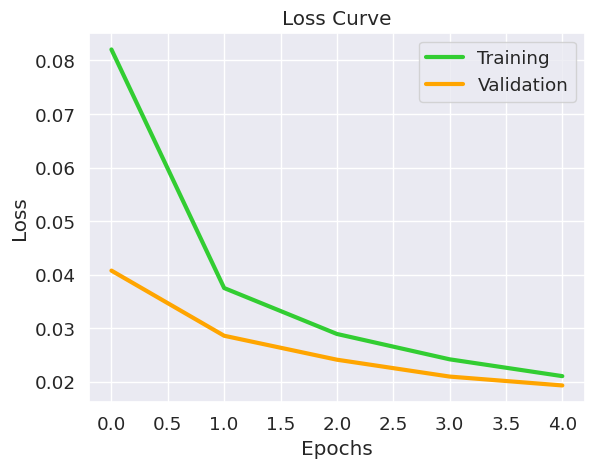

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history_bert.history['loss'],linewidth=3,color='limegreen')
plt.plot(history_bert.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

150/150 [==============================] - 16s 65ms/step


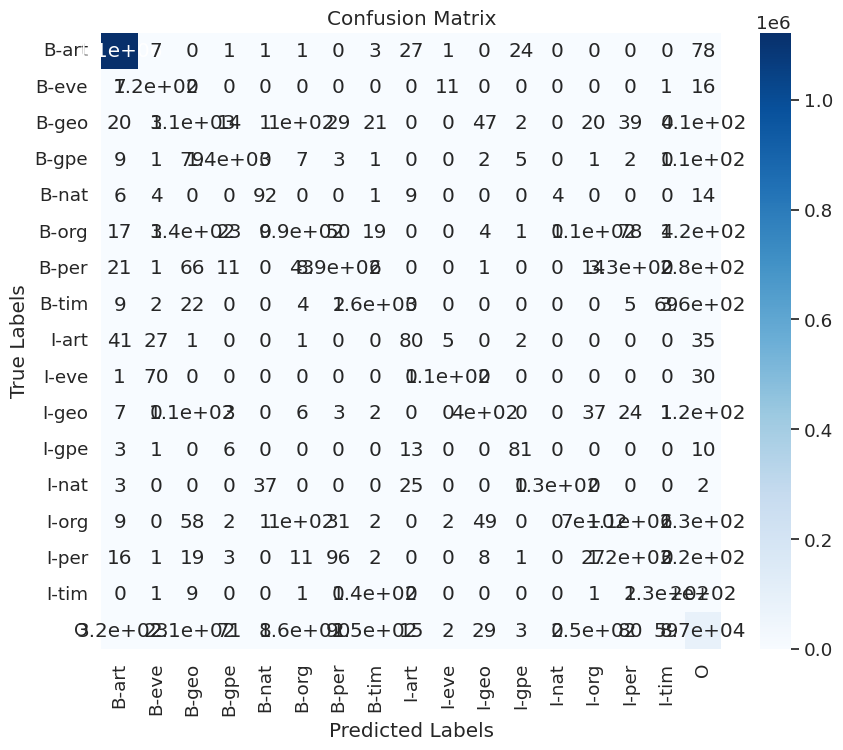

In [ ]:
predictions = model.predict([val_input_ids, val_attention_mask])
predicted_labels = np.argmax(predictions, axis=2)
true_labels_flat = np.concatenate(test_tag)
predicted_labels_flat = np.concatenate(predicted_labels)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_flat, predicted_labels_flat)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sns
label_names = enc_pos.classes_  # Assuming `enc_pos` is the label encoder used in your code

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_pred = np.argmax(model.predict([val_input_ids, val_attention_mask]), axis=2)
y_pred_labels = enc_pos.inverse_transform(y_pred.reshape(-1))
y_true_labels = np.array(test_tag).flatten()
encoded_pred_labels = enc_pos.transform(y_pred_labels)
from sklearn.metrics import classification_report
label_names = enc_pos.inverse_transform(np.arange(len(enc_pos.classes_)))

report = classification_report(y_true_labels, encoded_pred_labels, target_names=label_names)
print(report)


150/150 [==============================] - 5s 30ms/step
              precision    recall  f1-score   support

       B-art       1.00      1.00      1.00   1122445
       B-eve       0.47      0.78      0.59       160
       B-geo       0.77      0.81      0.79      3797
       B-gpe       0.91      0.86      0.89      1592
       B-nat       0.66      0.71      0.68       130
       B-org       0.69      0.48      0.57      2055
       B-per       0.75      0.53      0.62      1668
       B-tim       0.82      0.77      0.79      2033
       I-art       0.47      0.42      0.44       192
       I-eve       0.84      0.52      0.64       210
       I-geo       0.74      0.56      0.64       713
       I-gpe       0.68      0.71      0.70       114
       I-nat       0.97      0.65      0.78       193
       I-org       0.60      0.41      0.49      1699
       I-per       0.65      0.75      0.70      1658
       I-tim       0.63      0.39      0.48       585
           O       0.97  

Overall accuracy has not increased but the category wise accuracy has increased in many places. Oversampling and pretrained BERT has increase the score

## BERT Conclusion

In [ ]:
# Sample sentence
sample_sentence = "I wanted to go to Disney in America"

# Tokenize the sample sentence
tokens = tokenizer.encode_plus(np.array(sample_sentence.split()),
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


input_ids=tokens['input_ids']
attention_mask=tokens['attention_mask']

# Convert tokens to input IDs and attention mask
# input_ids = tokenizer.convert_tokens_to_ids(tokens)
# attention_mask = [1] * len(input_ids)

# Pad the input IDs and attention mask
input_ids = input_ids #+ [0] * (MAX_LEN - len(input_ids))
attention_mask = attention_mask #+ [0] * (MAX_LEN - len(attention_mask))

# Reshape the input IDs and attention mask for prediction
input_ids = np.array(input_ids).reshape(1, -1)
attention_mask = np.array(attention_mask).reshape(1, -1)

# Make predictions
predictions = model.predict([input_ids, attention_mask])
predicted_labels = np.argmax(predictions, axis=2)[0]

# Map the predicted labels to their corresponding tag names
predicted_tags = enc_pos.inverse_transform(predicted_labels)

# Print the tokens and predicted POS tags
for token, tag in zip(sample_sentence.split(), predicted_tags):
    print(f"Token: {token:<10} Predicted POS: {tag}")

1/1 [==============================] - 5s 5s/step
Token: I          Predicted POS: O
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: Disney     Predicted POS: B-org
Token: in         Predicted POS: O
Token: America    Predicted POS: B-geo
